✅ Data loaded: Train=54000, Val=6000, Test=10000

=== Training ANN Model ===
[ANN] Epoch 1/15 | Loss=0.9397 | Train Acc=0.6558 | Val Acc=0.7140
[ANN] Epoch 2/15 | Loss=0.7854 | Train Acc=0.7045 | Val Acc=0.7433
[ANN] Epoch 3/15 | Loss=0.7315 | Train Acc=0.7227 | Val Acc=0.7478
[ANN] Epoch 4/15 | Loss=0.7026 | Train Acc=0.7341 | Val Acc=0.7647
[ANN] Epoch 5/15 | Loss=0.6783 | Train Acc=0.7414 | Val Acc=0.7718
[ANN] Epoch 6/15 | Loss=0.6610 | Train Acc=0.7500 | Val Acc=0.7632
[ANN] Epoch 7/15 | Loss=0.6358 | Train Acc=0.7586 | Val Acc=0.7832
[ANN] Epoch 8/15 | Loss=0.6199 | Train Acc=0.7658 | Val Acc=0.7868
[ANN] Epoch 9/15 | Loss=0.6081 | Train Acc=0.7709 | Val Acc=0.7908
[ANN] Epoch 10/15 | Loss=0.5927 | Train Acc=0.7778 | Val Acc=0.7968
[ANN] Epoch 11/15 | Loss=0.5851 | Train Acc=0.7800 | Val Acc=0.8007
[ANN] Epoch 12/15 | Loss=0.5795 | Train Acc=0.7826 | Val Acc=0.7987
[ANN] Epoch 13/15 | Loss=0.5670 | Train Acc=0.7854 | Val Acc=0.7990
[ANN] Epoch 14/15 | Loss=0.5584 | Train Acc=0.79

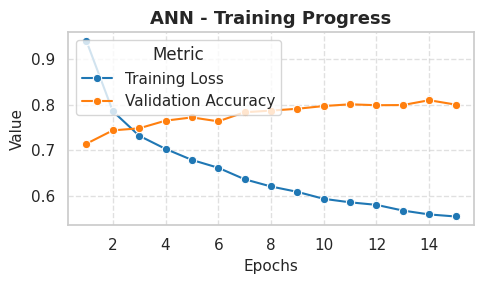


[ANN] Test Accuracy: 83.81%


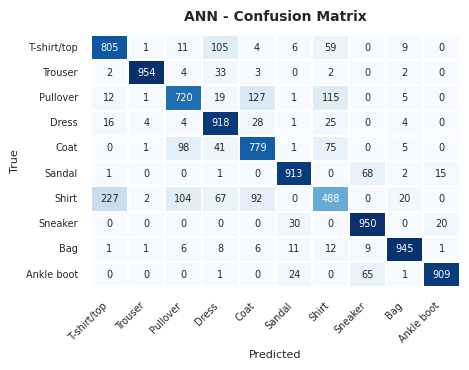


=== Training CNN Model ===
[CNN] Epoch 1/15 | Loss=0.7338 | Train Acc=0.7325 | Val Acc=0.7818
[CNN] Epoch 2/15 | Loss=0.5823 | Train Acc=0.7830 | Val Acc=0.8050
[CNN] Epoch 3/15 | Loss=0.5279 | Train Acc=0.8028 | Val Acc=0.8150
[CNN] Epoch 4/15 | Loss=0.5022 | Train Acc=0.8108 | Val Acc=0.8177
[CNN] Epoch 5/15 | Loss=0.4785 | Train Acc=0.8220 | Val Acc=0.8250
[CNN] Epoch 6/15 | Loss=0.4586 | Train Acc=0.8286 | Val Acc=0.8367
[CNN] Epoch 7/15 | Loss=0.4371 | Train Acc=0.8357 | Val Acc=0.8400
[CNN] Epoch 8/15 | Loss=0.4282 | Train Acc=0.8397 | Val Acc=0.8527
[CNN] Epoch 9/15 | Loss=0.4164 | Train Acc=0.8453 | Val Acc=0.8520
[CNN] Epoch 10/15 | Loss=0.4105 | Train Acc=0.8470 | Val Acc=0.8597
[CNN] Epoch 11/15 | Loss=0.4005 | Train Acc=0.8505 | Val Acc=0.8617
[CNN] Epoch 12/15 | Loss=0.3922 | Train Acc=0.8540 | Val Acc=0.8580
[CNN] Epoch 13/15 | Loss=0.3843 | Train Acc=0.8565 | Val Acc=0.8688
[CNN] Epoch 14/15 | Loss=0.3757 | Train Acc=0.8596 | Val Acc=0.8715
[CNN] Epoch 15/15 | Loss=0.36

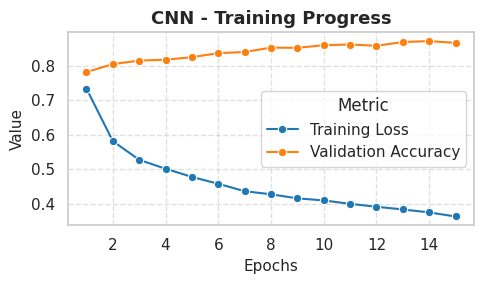


[CNN] Test Accuracy: 88.49%


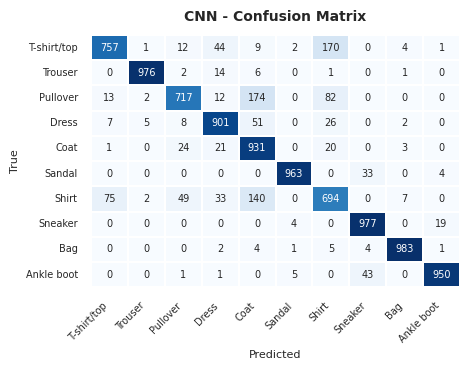



=== Summary ===
ANN Test Accuracy: 83.81%
CNN Test Accuracy: 88.49%


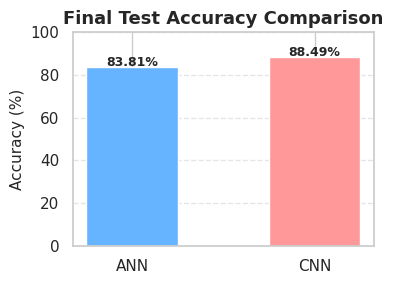

In [2]:
# =============================================================
# 0. Setup and Hyperparameters
# =============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
VAL_RATIO = 0.1
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# =============================================================
# 1. Data Preparation (Augmentation + Normalization)
# =============================================================
FASHION_MEAN = (0.2860,)
FASHION_STD = (0.3530,)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(FASHION_MEAN, FASHION_STD)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(FASHION_MEAN, FASHION_STD)
])

full_train_set = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform_train
)
test_set = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform_test
)

val_len = int(len(full_train_set) * VAL_RATIO)
train_len = len(full_train_set) - val_len
train_data, val_data = random_split(full_train_set, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data loaded: Train={train_len}, Val={val_len}, Test={len(test_set)}")

# =============================================================
# 2. ANN Model Definition
# =============================================================
class FashionANN(nn.Module):
    def __init__(self):
        super(FashionANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.4)

        # Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.softplus(self.bn1(self.fc1(x)))
        x = self.dropout(F.softplus(self.bn2(self.fc2(x))))
        x = F.softplus(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

# =============================================================
# 3. CNN Model Definition
# =============================================================
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = F.softplus(self.bn1(self.conv1(x)))
        x = self.pool(F.softplus(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(-1, 64 * 14 * 14)
        x = F.softplus(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x

# =============================================================
# 4. Training and Evaluation
# =============================================================
def get_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, model_name):
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.8)

    train_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        train_acc = correct / total
        val_acc = get_accuracy(model, val_loader)
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_accuracies.append(val_acc)
        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs} | "
              f"Loss={avg_loss:.4f} | Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")

    return train_losses, val_accuracies

def evaluate_model(model, test_loader, class_names, model_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n[{model_name}] Test Accuracy: {acc*100:.2f}%")
    return acc, cm

# =============================================================
# 5. Visualization
# =============================================================
sns.set_theme(style="whitegrid")

def plot_curves(train_losses, val_accs, model_name):
    epochs = range(1, len(train_losses) + 1)
    df = pd.DataFrame({
        "Epoch": list(epochs) * 2,
        "Value": train_losses + val_accs,
        "Metric": ["Training Loss"] * len(epochs) + ["Validation Accuracy"] * len(epochs)
    })
    plt.figure(figsize=(5, 3))
    sns.lineplot(data=df, x="Epoch", y="Value", hue="Metric", marker="o", palette="tab10")
    plt.title(f"{model_name} - Training Progress", fontsize=13, weight='bold')
    plt.xlabel("Epochs", fontsize=11)
    plt.ylabel("Value", fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes,
                linewidths=0.3, annot_kws={"size": 7})
    plt.title(f"{model_name} - Confusion Matrix", fontsize=10, weight='bold', pad=10)
    plt.xlabel("Predicted", fontsize=8)
    plt.ylabel("True", fontsize=8)
    plt.xticks(rotation=45, ha="right", fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout(pad=1.5)
    plt.show()

# =============================================================
# 6. Main Execution
# =============================================================
if __name__ == '__main__':
    print("\n=== Training ANN Model ===")
    ann = FashionANN()
    ann_losses, ann_val_accs = train_model(ann, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, "ANN")
    plot_curves(ann_losses, ann_val_accs, "ANN")
    ann_acc, ann_cm = evaluate_model(ann, test_loader, CLASS_NAMES, "ANN")
    plot_confusion_matrix(ann_cm, CLASS_NAMES, "ANN")

    print("\n=== Training CNN Model ===")
    cnn = FashionCNN()
    cnn_losses, cnn_val_accs = train_model(cnn, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, "CNN")
    plot_curves(cnn_losses, cnn_val_accs, "CNN")
    cnn_acc, cnn_cm = evaluate_model(cnn, test_loader, CLASS_NAMES, "CNN")
    plot_confusion_matrix(cnn_cm, CLASS_NAMES, "CNN")


    print("\n" + "="*60 + "\n")

    # =========================================================
    # 7. Model Comparison Visualization
    # =========================================================
    def compare_models(ann_val_accs, cnn_val_accs, ann_acc, cnn_acc):
        epochs = range(1, len(ann_val_accs) + 1)

        print("=== Summary ===")
        print(f"ANN Test Accuracy: {ann_acc*100:.2f}%")
        print(f"CNN Test Accuracy: {cnn_acc*100:.2f}%")


        models = ['ANN', 'CNN']
        accuracies = [ann_acc * 100, cnn_acc * 100]
        colors = ['#66b3ff', '#ff9999']

        plt.figure(figsize=(4, 3))
        plt.bar(models, accuracies, color=colors, width=0.5)
        plt.title("Final Test Accuracy Comparison", fontsize=13, weight='bold')
        plt.ylabel("Accuracy (%)", fontsize=11)
        for i, v in enumerate(accuracies):
            plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontsize=9, weight='bold')
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


    compare_models(ann_val_accs, cnn_val_accs, ann_acc, cnn_acc)
